# Med Student Qualtrics Results - Clinical Questionaire
------
The clinical questionaire is comprised of 3 tasks (Diabetes, Hypertension, Depression) and 21 questions. There are several ways to begin analyzing the data set:

- **Read-in the data**
- Score (Number of correctly answered questions)
    - [Overall](#oscore)
    - [Tier 1](#tier1)
    - [Tier 2](#tier2)
    - [Tier 3](#tier3)
- [Time-to-Complete](#ttc)
- [Individual-Question Comparisons](#iqc)


## Read-in the data
-----
Before we begin looking at data, we need to read it in. In this next step, we will read in the data from the clinical questionaire (both control and intervention surveys) as well as some metadata about the survey itself.

In [1]:
%matplotlib inline
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap

cq_control = pd.read_csv(header=1,filepath_or_buffer=open("./med_student_materials/qualtrics_data/KaiRx_Clinical_Questionnaire__Control.csv","rb"))
cq_interve = pd.read_csv(header=1,filepath_or_buffer=open("./med_student_materials/qualtrics_data/KaiRx_Clinical_Questionnaire__Intervention.csv","rb"))
dd = json.load(open("./med_student_materials/qualtrics_data/KaiRx_Clinical_Questionnaire_-_Control.qsf.txt","r"))
#we'll need labels for things so let's go ahead and create them
cq_interve['label'] = "intervention"
cq_control['label'] = "control"
#We'll need a function to help extract needed metadata
def dict_2_list(d):
    out_list = []
    for key, value in d.items():
        out_list.append(value['Display'])
    return(out_list)

#From the metadata, we'll need to create two lists: (1) Question Names and (2) Question Choices
question_text = []
question_choi = []
for i,x in enumerate(dd['SurveyElements']): 
    if isinstance(x['Payload'], dict):
        if 'Choices' in list(x['Payload'].keys()):
            question_text.append(x['Payload']['QuestionText'])
            question_choi.append(dict_2_list(x['Payload']['Choices']))
            
print(question_text[0])
print(question_choi[0])

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


10. He did not pick up his last allopurinol prescription at the pharmacy. What other agents was he prescribed to treat gout in the past?&nbsp;<b>(Check all that apply.)&nbsp;</b>
['d. Bupropion', 'a. No other medications have been prescribed for gout.', 'e. Colchicine', 'b. Probenecid', 'c. Naproxen']


## Score
------
Each question is worth 1 point, except for 3 multiple choice questions. For these 3 questions, there are 2 correct answers. This leads to a variable whose min is 0 and max is 24. This variable can be divided into four areas of interest - overall and by each section. For each of the four sections. We will provide a side by side histogram (control vs. intervention). We will then investigate two assumptions to determine the best test:
- Homogeneity of Variance
- Normality

<a id='oscore'></a>
### Overall
---------
*The overall score has a possible maximum of **24**.*

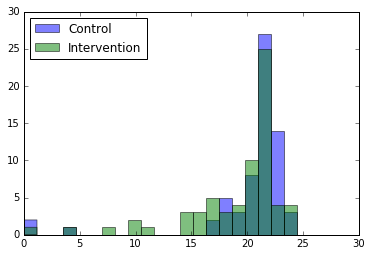

In [2]:
#Make a histogram
import random
import numpy
from matplotlib import pyplot

x = cq_control['Score-sum']
y = cq_interve['Score-sum']

bins = numpy.linspace(0, 28, 25)

pyplot.hist(x, bins, alpha=0.5, label='Control')
pyplot.hist(y, bins, alpha=0.5, label='Intervention')
pyplot.legend(loc='upper left')
pyplot.show()

>From here, we have two choices: (1) try to normalize and proceed with parametric tests or (2) use non-parametric tests. Since I'm not sure what a log(score) differnce would represent (or what would be meaningful), I'll not transform and will just go with nonparametric tests. We'll use scipy.stats.levene using the median. From what I can tell this seems to be an implementation of the [Brown-Forsynthe](https://en.wikipedia.org/wiki/Brown–Forsythe_test) test (although I'll want to confirm before putting to print).

In [3]:
import scipy.stats
print("Levene's test restuls: \n*************************************************")
print(scipy.stats.levene(x,y,center='median'))

Levene's test restuls: 
*************************************************
LeveneResult(statistic=0.8381413358679799, pvalue=0.36162396600378599)


> The p-value is .36 which means that we don't have evidence to reject the null hypothesis of equal variances (this suggests the variances **are** equal). The [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Equal_or_unequal_sample_sizes.2C_equal_variance) is reasonable robust against violations of normailty, so we will proceed with this test to determine if the null hypothesis of average time-to-complete is equal among the two groups. In other words:
$$H_{0}:\hat{\mu}_{control}=\hat{\mu}_{intervention}$$

In [4]:
print("T Test results: ")
print(scipy.stats.ttest_ind(x,y))

T Test results: 
Ttest_indResult(statistic=1.6844623866824837, pvalue=0.094491758817951119)


> The p-value of 0.0945 indicates that there is no evidence to reject the null (seems that the distributions of both populations are equal). **Note, I think this was done on the data that did not correct for question 3, so once that correction is in place, the p-value will probably be even higher.**

<a id='tier1'></a>
### Tier 1 
---------

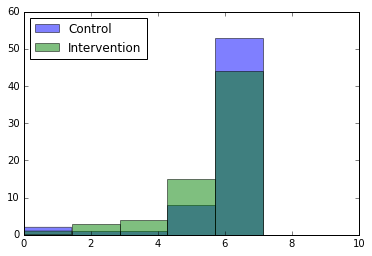

In [5]:
#Before we begin in on the "tiered" questions, we need to identify 'correct' answers, which are located here:
meta = json.load(open('./med_student_materials/qualtrics_data/KaiRx_Clinical_Questionnaire_-_Control.qsf','r'))
new = dict()
for i,x in enumerate(meta.get('SurveyElements')):
    payload = x.get('Payload')
    if isinstance(payload,dict):
        if any("GradingData" in s for s in list(payload.keys())):
            answers = payload.get('GradingData')
            text = []
            for z in answers:
                answer = z.get('ChoiceID')
                text.append(payload.get('Choices').get(answer).get('Display'))
            new[payload.get('QuestionDescription')] = text
#for each tiered question list, we explicitly label:
tier1 = ['4. You ask him about his diabetes medications and you can trust that he is telling you the truth...',
         '6. You realize that he has already taken the maximum dose of metformin for awhile without much ch...',
         '7. What was the starting dose of allopurinol prescribed for Mr. Smith? What was the last prescrib...',
         '8. Who prescribed his last refill of allopurinol? ',
         '3. You ask Mr. Smith about the details of his depression medication changes in the past but he ha...',
         'Task 1: Diabetes 1. Which medication(s) is the patient currently taking for diabetes? '
         ]

#We'll need a function to provide a participant score
def returnScore(row,qlist):
    score=0
    for x in qlist:
        if '...' in x:
            metax = x.split('...',1)[0]+'...'
        elif '2. Which drugs have been escalated in dose' in x:
            metax = '2. Which drugs have been escalated in dose at least twice?\xa0(Check all that apply.)\xa0'
        else:
            metax = x
        if (row[x] in new.get(metax)):
            score+=1
    return(score)

#and finally, we'll need to score each leg of the experiment
tier1_control = cq_control.apply(lambda row: returnScore(row,tier1),axis=1)
tier1_interve = cq_interve.apply(lambda row: returnScore(row,tier1),axis=1)

bins = numpy.linspace(0, 10, 8)

pyplot.hist(tier1_control, bins, alpha=0.5, label='Control')
pyplot.hist(tier1_interve, bins, alpha=0.5, label='Intervention')
pyplot.legend(loc='upper left')
pyplot.show()

#### Inference
Using the t-test, we'll determine if there is a **significant** difference.

In [6]:
print("T Test results: ")
print(scipy.stats.ttest_ind(tier1_control,tier1_interve))

T Test results: 
Ttest_indResult(statistic=1.0974884041702391, pvalue=0.27445661858383619)


> Results: The p-value is > 0.05, meaning we don't have enough evidence to support an alternative hypothesis that the means are equal. Stated another way, there is no difference in means for the tier 1 questions.

In [7]:
print('Tier 1 Control Summary: ')
print(tier1_control.describe())
print('\n')
print('Tier 1 Intervention Summary: ')
print(tier1_interve.describe())

Tier 1 Control Summary: 
count    65.000000
mean      5.600000
std       1.183216
min       0.000000
25%       6.000000
50%       6.000000
75%       6.000000
max       6.000000
dtype: float64


Tier 1 Intervention Summary: 
count    67.000000
mean      5.373134
std       1.191330
min       0.000000
25%       5.000000
50%       6.000000
75%       6.000000
max       6.000000
dtype: float64


<a id='tier2'></a>
### Tier 2
---------

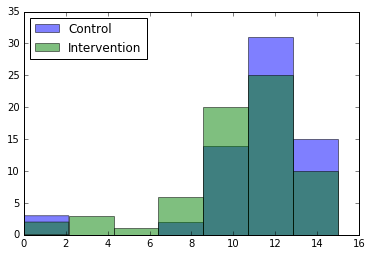

In [8]:
#comprehension         
tier2 = ['2. How long has he been taking his diabetes medication(s)?',
         '3. Has he been compliant with his diabetes medication? How do you know? ',
         '5. You see that he is currently on this maximum dose. You are wondering how recently this last ch...',
         '9. You see a prescription but wonder if he has picked up his last prescription of allopurinol. Ba...',
         '10. He did not pick up his last allopurinol prescription at the pharmacy. What other agents was h...-c. Naproxen',
         '10. He did not pick up his last allopurinol prescription at the pharmacy. What other agents was h...-e. Colchicine',
         'Task 2: Hypertension 1. Mr. Smith was diagnosed with hypertension 20 years ago. What was the firs...',
         '3. Over time, Mr. Smith’s blood pressure still continued to increase despite his compliance with...',
         'Task 3: Depression  1. You continue with your check-up. The patient has a long-standing history o...-a. Selective serotonin reuptake inhibitors (SSRIs)',
         'Task 3: Depression  1. You continue with your check-up. The patient has a long-standing history o...-e. Atypical antidepressants',
         '2. Which drugs have been escalated in dose at least twice? (Check all that apply.) -b. Sertraline',
         '2. Which drugs have been escalated in dose at least twice? (Check all that apply.) -c. Fluoxetine',
         '4. You’d like to know what date that provider changed the medication so you can investigate the n...'
         ]

tier2_control = cq_control.apply(lambda row: returnScore(row,tier2),axis=1)
tier2_interve = cq_interve.apply(lambda row: returnScore(row,tier2),axis=1)

bins = numpy.linspace(0, 15, 8)

pyplot.hist(tier2_control, bins, alpha=0.5, label='Control')
pyplot.hist(tier2_interve, bins, alpha=0.5, label='Intervention')
pyplot.legend(loc='upper left')
pyplot.show()

#### Inference:
Using a t-test we'll test for a difference in means.

In [9]:
print("T Test results: ")
print(scipy.stats.ttest_ind(tier2_control,tier2_interve))

T Test results: 
Ttest_indResult(statistic=1.9072939163446152, pvalue=0.058688597459039829)


> Results: We still can't claim enough evidence for a difference, but the p-value is really close this time (0.059). Let's look at the means of each arm to see what we would be able to say if we had collected a little more data (potentially).

In [10]:
print('Tier 2 Control Summary: ')
print(tier2_control.describe())
print('\n')
print('Tier 2 Intervention Summary: ')
print(tier2_interve.describe())

Tier 2 Control Summary: 
count    65.000000
mean     10.953846
std       2.671790
min       0.000000
25%      10.000000
50%      12.000000
75%      12.000000
max      13.000000
dtype: float64


Tier 2 Intervention Summary: 
count    67.000000
mean     10.059701
std       2.712935
min       0.000000
25%       9.500000
50%      11.000000
75%      12.000000
max      13.000000
dtype: float64


>Almost certainly, if we collected more data, we would have obtained a p-value < 0.05 claiming enough evidence for a difference, but then what. These summary measures would have indicated that the **Control** arm seems to have a higher (on average) tier 2 score than the intervention. Suggesting the control is **better** (on average) for comprehension.

<a id='tier3'></a>
### Tier 3
---------

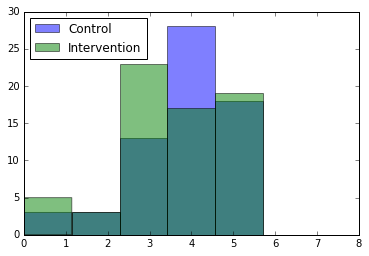

In [11]:
#projection
tier3 = ['11. After asking the patient about his gout, he explains that he has not picked up his gout medic...',
         '2. The patient’s blood pressure did not decrease in the 3 years after he was prescribed the thiaz...',
         '4. What do you suspect happened with his new antihypertensive regimen of HCTZ + ACE inhibitor tha...',
         '5. Despite Mr. Smith’s diligent adherence to his exercise and diet regimen and his past medicatio...',
         '5. Why do you think the provider chose bupropion to prescribe in 2006? '
         ]

tier3_control = cq_control.apply(lambda row: returnScore(row,tier3),axis=1)
tier3_interve = cq_interve.apply(lambda row: returnScore(row,tier3),axis=1)

bins = numpy.linspace(0, 8, 8)

pyplot.hist(tier3_control, bins, alpha=0.5, label='Control')
pyplot.hist(tier3_interve, bins, alpha=0.5, label='Intervention')
pyplot.legend(loc='upper left')
pyplot.show()


#### Inference:
Using a t-test we'll test for a difference in means.

In [12]:
print("T Test results: ")
print(scipy.stats.ttest_ind(tier3_control,tier3_interve))

T Test results: 
Ttest_indResult(statistic=1.0175512943092071, pvalue=0.3107812446719993)


>Results: The p-value (0.31) is greater than 0.05, meaning there is no evidence for the alternative hypothesis of unequal means between the two arms of the study.

In [13]:
print('Tier 3 Control Summary: ')
print(tier3_control.describe())
print('\n')
print('Tier 3 Intervention Summary: ')
print(tier3_interve.describe())

Tier 3 Control Summary: 
count    65.000000
mean      3.800000
std       1.175266
min       0.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       5.000000
dtype: float64


Tier 3 Intervention Summary: 
count    67.000000
mean      3.582090
std       1.280971
min       0.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       5.000000
dtype: float64


<a id='ttc'></a>
### Time-to-Complete
---------
*For this analysis, we will convert seconds to minutes to make interpretation and visualization easier.*

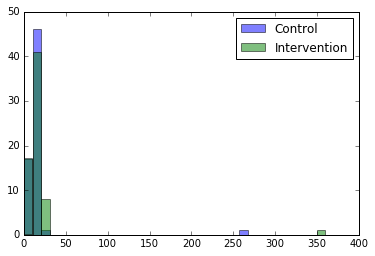

In [14]:
x = cq_control['Q_TotalDuration']
x_min = x/60
x_min_trunc = x_min[x_min<250]
y = cq_interve['Q_TotalDuration']
y_min = y/60
y_min_trunc = y_min[y_min<250]

bins = numpy.linspace(0, 360, 36)

pyplot.hist(x_min, bins, alpha=0.5, label='Control')
pyplot.hist(y_min, bins, alpha=0.5, label='Intervention')
pyplot.legend(loc='upper right')
pyplot.show()

> As seen above, it appears there are two outliers (one in each arm), for this analysis (only) we will remove these two surveys.

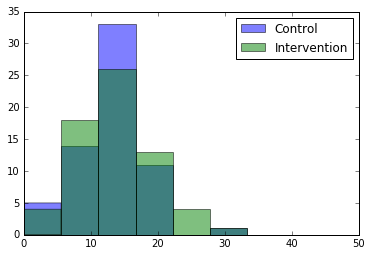

In [15]:
bins = numpy.linspace(0, 50, 10)

pyplot.hist(x_min_trunc, bins, alpha=0.5, label='Control')
pyplot.hist(y_min_trunc, bins, alpha=0.5, label='Intervention')
pyplot.legend(loc='upper right')
pyplot.show()

> With this view of the data, it appears to at least be visually close to normal. However, we'll use the [Shapiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro–Wilk_test) to officially test this assumption, what about the assumption of homogeniety of variance? The null hypothesis in this case is:
$$H_{0}:\hat{\sigma}_{control}=\hat{\sigma}_{intervention}$$
>We'll use [Levene's Test](https://en.wikipedia.org/wiki/Levene%27s_test) to offically test.

In [16]:
import scipy.stats
print("Levene's test restuls: \n*************************************************")
print(scipy.stats.levene(x_min_trunc,y_min_trunc))
print("\n")
print("Shapiro-Wilk results for the control group: \n*************************************************")
print(scipy.stats.shapiro(x_min_trunc))
print("\n")
print("Shapiro-Wilk results for the intervention group: \n*************************************************")
print(scipy.stats.shapiro(y_min_trunc))

Levene's test restuls: 
*************************************************
LeveneResult(statistic=1.3748071116488576, pvalue=0.2431652326442863)


Shapiro-Wilk results for the control group: 
*************************************************
(0.9491214156150818, 0.010360966436564922)


Shapiro-Wilk results for the intervention group: 
*************************************************
(0.9855010509490967, 0.6367889046669006)


>We find no evidence against the assumption of equal variances. We find marginal evidence to suggest a non-Gaussian distribution in the Control group (p-value is 0.0103); however, the [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Equal_or_unequal_sample_sizes.2C_equal_variance) is reasonable robust against violations of normailty, so we will proceed with this test to determine if the null hypothesis of average time-to-complete is equal among the two groups. In other words:
$$H_{0}:\hat{\mu}_{control}=\hat{\mu}_{intervention}$$

In [17]:
print("Student's t-test restuls: \n*************************************************")
print(scipy.stats.ttest_ind(x_min_trunc,y_min_trunc))

Student's t-test restuls: 
*************************************************
Ttest_indResult(statistic=-0.86970842639800916, pvalue=0.38608775211172597)


>The p-value is 0.386, suggesting that there is no evidence again the null hypothesis of equal average completion times. To finish this objective, we present overall summary measures for each variable:

In [18]:
print('Total Time Duration Control Summary: ')
print(x_min_trunc.describe())
print('\n')
print('Total Time Duration Intervention Summary: ')
print(y_min_trunc.describe())

Total Time Duration Control Summary: 
count    64.000000
mean     12.767188
std       5.038104
min       0.416667
25%      10.220833
50%      13.125000
75%      15.187500
max      29.583333
Name: Q_TotalDuration, dtype: float64


Total Time Duration Intervention Summary: 
count    66.000000
mean     13.586869
std       5.677501
min       0.216667
25%      10.112500
50%      12.750000
75%      16.833333
max      28.816667
Name: Q_TotalDuration, dtype: float64


#### Remove the "low" outliers too?
After seeing the results above, there was a question on 9/21/2016 about whether the low outliers should be removed. A time cutoff of 3 or 5 minutes was suggested. Defining an outlier as 1.5 times the IQR would suggest something within this range. There's a real question about the "feasibility" of whether these are valid records. To help aid in the decision around this cutoff the following figure is provided.

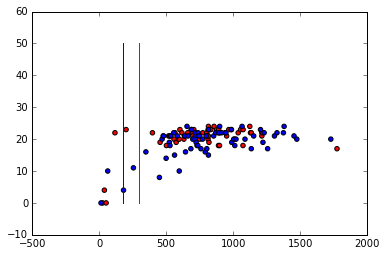

In [61]:
look_control = cq_control[['Q_TotalDuration','Score-sum']].sort_values(['Q_TotalDuration'])
look_control['type'] = 'control'
look_control = look_control[look_control['Q_TotalDuration']<5000]

look_interve = cq_interve[['Q_TotalDuration','Score-sum']].sort_values(['Q_TotalDuration'])
look_interve['type'] = 'intervention'
look_interve = look_interve[look_interve['Q_TotalDuration']<5000]

color1 = ['red' for item in range(look_control.shape[0])]
color2 = ['blue' for item in range(look_interve.shape[0])]
color = color1 + color2
look = look_control.append(look_interve)


plt.scatter(look['Q_TotalDuration'],look['Score-sum'],c=color)
plt.plot((180,180),(0,50))
plt.plot((300,300),(0,50))
plt.show()

<a id='iqc'></a>
### Individual-Question Comparisons
---------
The survey was comprised of the following questions, which, on an individual level can be used to compare control and intervention:
- **Diabetes** 
    - [*Multinomial* 1. Which medication(s) is the patient currently taking for diabetes?](#d1)
    - [*Multinomial* 2. How long has he been taking his diabetes medication(s)?](#d2)
    - [*Multinomial* 3. Has he been compliant with his diabetes medication? How do you know?](#d3)
    - [*Binomial* 4. You ask him about his diabetes medications and you can trust](#d4)
    - [*Multinomial* 5. You see that he is currently on this maximum dose. You are wondering how recently](#d5)
    - [*Multinomial* 6. You realize that he has already taken the maximum dose of metformin for awhile](#d6)
    - [*Multinomial* 7. What was the starting dose of allopurinol prescribed for Mr. Smith?](#d7)
    - [*Multinomial* 8. Who prescribed his last refill of allopurinol?](#d8)
    - [*Multinomial* 9. You see a prescription but wonder if he picked up his last prescription allopurinol.](#d9)
    - [*Multiple Choice* 10. He did not pick up his last allopurinol prescription at the pharmacy.](#d10)
    - [*Multinomial* 11. After asking the patient about his gout, he explains](#d11)
- **Hypertension**
    - [*Multinomial* 1. Mr. Smith was diagnosed with hypertension 20 years ago.](#h1)
    - [*Multinomial* 2. The patient’s blood pressure did not decrease in the 3 years after he](#h2)
    - [*Multinomial* 3. Over time, Mr. Smith’s blood pressure still continued to increase](#h3)
    - [*Multinomial* 4. What do you suspect happened with his new antihypertensive regimen](#h4)
    - [*Multinomial* 5. Despite Mr. Smith’s diligent adherence to his exercise and diet](#h5)
- **Depression**
    - [*Multiple Choice* 1. You continue with your check-up. The patient has](#de1)
    - [*Multiple Choice* 2. Which drugs have been escalated in dose at least twice?](#de2)
    - [*Multinomial* 3. You ask Mr. Smith about the details of his depression medication changes](#de3)
    - [*Multinomial* 4. You’d like to know what date that provider changed the medication so you](#de4)
    - [*Multinomial* 5. Why do you think the provider chose bupropion to prescribe in 2006?](#de5)

# Diabetes
--------
**Note all individual questions will contain both a bar graph and then a contingency table with a chi-square p-value. I will only provide an explantion for the first one, but using this as a template, it can be applied to all quesitons in the same manner.*

<a id='d1'></a>
### 1. Which medication(s) is the patient currently taking for diabetes?
------------
*Multinomial*

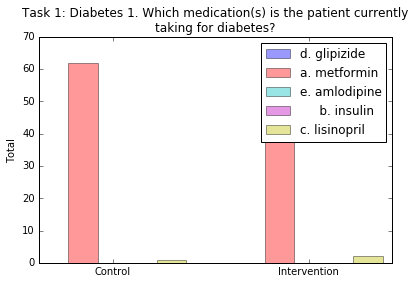

In [20]:
from utils import createBarPlot
questionsName = 'Task 1: Diabetes 1. Which medication(s) is the patient currently taking for diabetes? '
dd_number = 18
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [21]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(0.0016620284477427451, 0.96748086389709298, 1, array([[ 61.53488372,  64.46511628],
       [  1.46511628,   1.53488372]]))
Arm                                                 control  intervention
Task 1: Diabetes 1. Which medication(s) is the ...                       
a. metformin                                             62            64
c. lisinopril                                             1             2


## Interpretation
-------
Notice that I first print out the chi-square "test of independence" first. These results look like (number, number, number, array([[blah]]). The first number is the chi-square test statistic (it is used to derive the p-value), the next number is the p-value, the next number is the degrees of freedom of the test, and the array bit is the calculated expected values. We mainly care about the **second number for inference**. In this example that means 0.9674, indicating there is not enough evidence to reject the null hypothesis of:
$$H_{0}:The observed and expected frequencies equal$$
Because we can't reject this null hypothesis - we conclude that the two variables are independent of one another (no association. Of course, we should always just state we don't have enough evidence (yet) to reject the null hypothesis.

<a id='d2'></a>
### 2. How long has he been taking his diabetes medication(s)?
------------
*Multinomial*

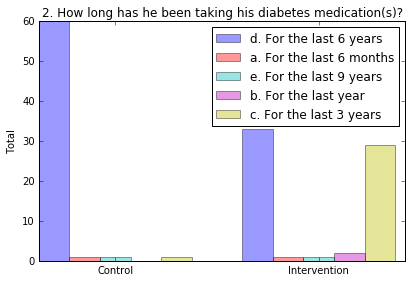

In [22]:
questionsName = '2. How long has he been taking his diabetes medication(s)?'
dd_number = 2
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [23]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(35.921703207187079, 3.003026036072191e-07, 4, array([[  0.97674419,   1.02325581],
       [  0.97674419,   1.02325581],
       [ 14.65116279,  15.34883721],
       [ 45.41860465,  47.58139535],
       [  0.97674419,   1.02325581]]))
Arm                                                 control  intervention
2. How long has he been taking his diabetes med...                       
a. For the last 6 months                                  1             1
b. For the last year                                      0             2
c. For the last 3 years                                   1            29
d. For the last 6 years                                  60            33
e. For the last 9 years                                   1             1


<a id='d3'></a>
### 3. Has he been compliant with his diabetes medication?
------------
*Multinomial*

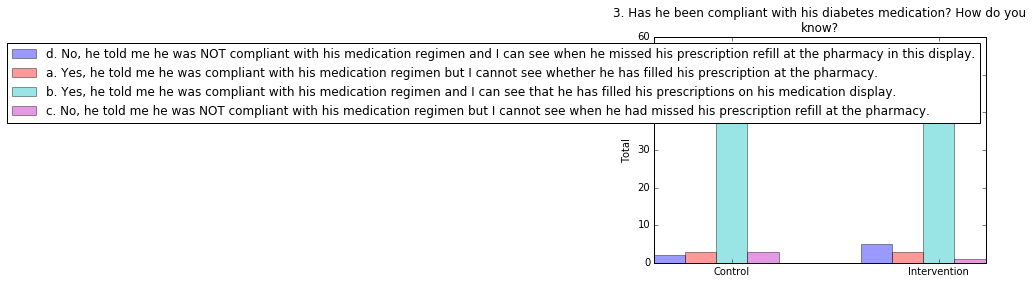

In [24]:
questionsName = '3. Has he been compliant with his diabetes medication? How do you know? '
dd_number = 5
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [25]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(2.2528795609152752, 0.5216079825806994, 3, array([[  2.93023256,   3.06976744],
       [ 54.69767442,  57.30232558],
       [  1.95348837,   2.04651163],
       [  3.41860465,   3.58139535]]))
Arm                                                 control  intervention
3. Has he been compliant with his diabetes medi...                       
a. Yes, he told me he was compliant with his me...        3             3
b. Yes, he told me he was compliant with his me...       55            57
c. No, he told me he was NOT compliant with his...        3             1
d. No, he told me he was NOT compliant with his...        2             5


<a id='d4'></a>
### 4. You ask him about his diabetes medications and you can trust
------------
*Binomial*

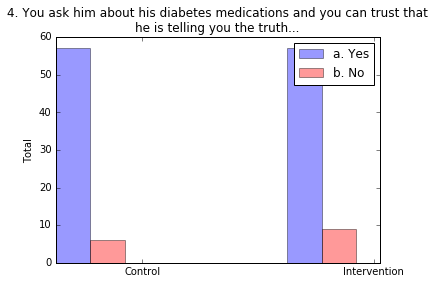

In [26]:
questionsName =  '4. You ask him about his diabetes medications and you can trust that he is telling you the truth...'
dd_number = 9
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [27]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(0.20578244854560612, 0.65009335474013885, 1, array([[ 55.6744186,  58.3255814],
       [  7.3255814,   7.6744186]]))
Arm                                                 control  intervention
4. You ask him about his diabetes medications a...                       
a. Yes                                                   57            57
b. No                                                     6             9


<a id='d5'></a>
### 5. You see that he is currently on this maximum dose. You are wondering how recently
------------
*Multinomial*

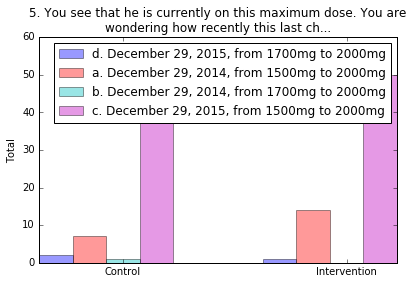

In [28]:
questionsName =  '5. You see that he is currently on this maximum dose. You are wondering how recently this last ch...'
dd_number = 13
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [29]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(3.6370456867610566, 0.30341787353683874, 3, array([[ 10.2519685 ,  10.7480315 ],
       [  0.48818898,   0.51181102],
       [ 49.79527559,  52.20472441],
       [  1.46456693,   1.53543307]]))
Arm                                                 control  intervention
5. You see that he is currently on this maximum...                       
a. December 29, 2014, from 1500mg to 2000mg               7            14
b. December 29, 2014, from 1700mg to 2000mg               1             0
c. December 29, 2015, from 1500mg to 2000mg              52            50
d. December 29, 2015, from 1700mg to 2000mg               2             1


<a id='d6'></a>
### 6. You realize that he has already taken the maximum dose of metformin for awhile
------------
*Multinomial*

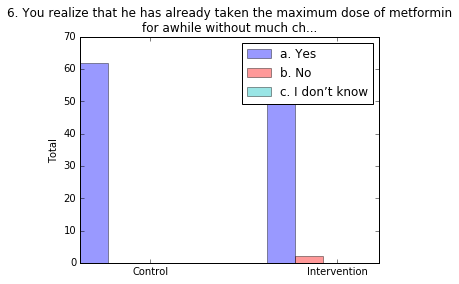

In [30]:
questionsName =  '6. You realize that he has already taken the maximum dose of metformin for awhile without much ch...'
dd_number = 14
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [31]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(0.46139131513647647, 0.49697445711249988, 1, array([[ 61.02362205,  63.97637795],
       [  0.97637795,   1.02362205]]))
Arm                                                 control  intervention
6. You realize that he has already taken the ma...                       
a. Yes                                                   62            63
b. No                                                     0             2


<a id='d7'></a>
### 7. What was the starting dose of allopurinol prescribed for Mr. Smith?
------------
*Multinomial*

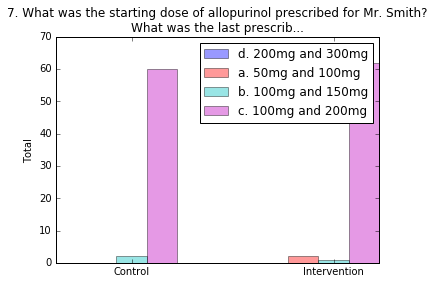

In [32]:
questionsName =  '7. What was the starting dose of allopurinol prescribed for Mr. Smith? What was the last prescrib...'
dd_number = 15
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [33]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(2.2965355462446948, 0.3171857314275639, 2, array([[  0.97637795,   1.02362205],
       [  1.46456693,   1.53543307],
       [ 59.55905512,  62.44094488]]))
Arm                                                 control  intervention
7. What was the starting dose of allopurinol pr...                       
a. 50mg and 100mg                                         0             2
b. 100mg and 150mg                                        2             1
c. 100mg and 200mg                                       60            62


<a id='d8'></a>
### 8. Who prescribed his last refill of allopurinol?
------------
*Multinomial*

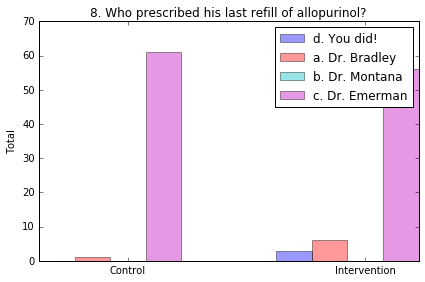

In [34]:
questionsName = '8. Who prescribed his last refill of allopurinol? '
dd_number = 16
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [35]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(6.717986287217057, 0.034770249974731542, 2, array([[  3.41732283,   3.58267717],
       [ 57.11811024,  59.88188976],
       [  1.46456693,   1.53543307]]))
Arm                                                 control  intervention
8. Who prescribed his last refill of allopurinol?                        
a. Dr. Bradley                                            1             6
c. Dr. Emerman                                           61            56
d. You did!                                               0             3


<a id='d9'></a>
### 9. You see a prescription but wonder if he picked up his last prescription allopurinol.
------------
*Multinomial*

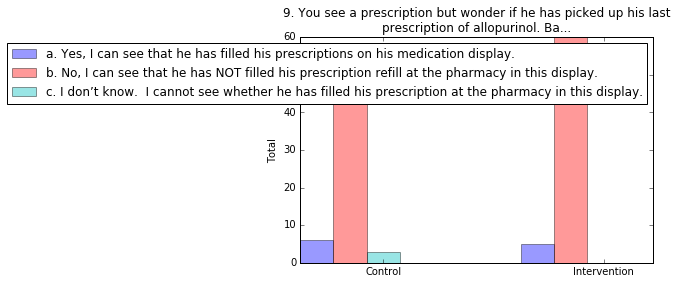

In [36]:
questionsName = '9. You see a prescription but wonder if he has picked up his last prescription of allopurinol. Ba...'
dd_number = 17
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [37]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(3.4555994961361778, 0.17767490977685144, 2, array([[  5.37007874,   5.62992126],
       [ 55.16535433,  57.83464567],
       [  1.46456693,   1.53543307]]))
Arm                                                 control  intervention
9. You see a prescription but wonder if he has ...                       
a. Yes, I can see that he has filled his prescr...        6             5
b. No, I can see that he has NOT filled his pre...       53            60
c. I don’t know.  I cannot see whether he has f...        3             0


<a id='d10'></a>
### 10. He did not pick up his last allopurinol prescription at the pharmacy.
------------
*Multiple Choice*

<a id='d11'></a>
### 11. After asking the patient about his gout, he explains
------------
*Multinomial*

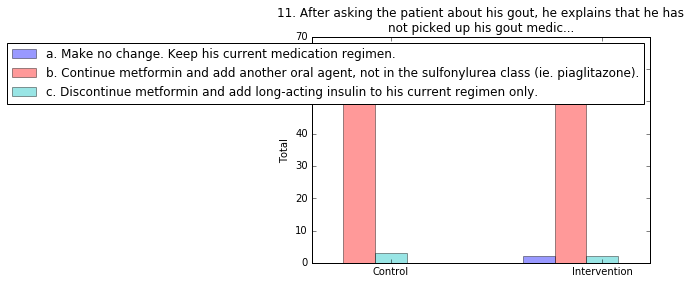

In [38]:
questionsName = '11. After asking the patient about his gout, he explains that he has not picked up his gout medic...'
dd_number = 1
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [39]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(2.163674524400331, 0.3389721724293222, 2, array([[  0.97637795,   1.02362205],
       [ 58.58267717,  61.41732283],
       [  2.44094488,   2.55905512]]))
Arm                                                 control  intervention
11. After asking the patient about his gout, he...                       
a. Make no change. Keep his current medication ...        0             2
b. Continue metformin and add another oral agen...       59            61
c. Discontinue metformin and add long-acting in...        3             2


# Hypertension
---------

<a id='h1'></a>
### 1. Mr. Smith was diagnosed with hypertension 20 years ago.
------------
*Multinomial*

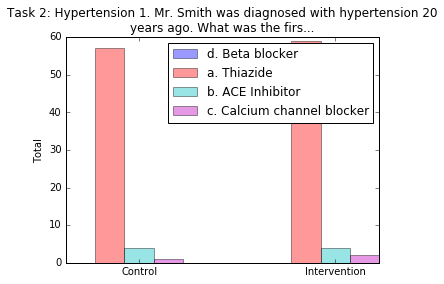

In [40]:
questionsName = 'Task 2: Hypertension 1. Mr. Smith was diagnosed with hypertension 20 years ago. What was the firs...'
dd_number = 19
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [41]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(0.29711574113687578, 0.8619501241834826, 2, array([[ 56.62992126,  59.37007874],
       [  3.90551181,   4.09448819],
       [  1.46456693,   1.53543307]]))
Arm                                                 control  intervention
Task 2: Hypertension 1. Mr. Smith was diagnosed...                       
a. Thiazide                                              57            59
b. ACE Inhibitor                                          4             4
c. Calcium channel blocker                                1             2


<a id='h2'></a>
### 2. The patient’s blood pressure did not decrease in the 3 years after he
------------
*Multinomial*

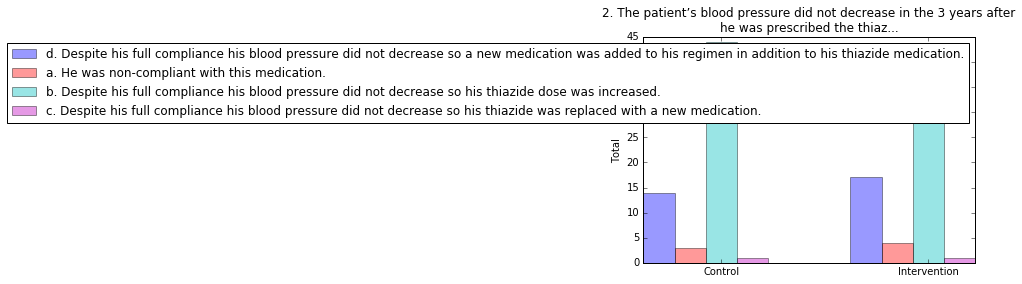

In [42]:
questionsName = '2. The patient’s blood pressure did not decrease in the 3 years after he was prescribed the thiaz...'
dd_number = 3
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [43]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(0.4480582091087294, 0.93014527697150617, 3, array([[  3.44444444,   3.55555556],
       [ 42.31746032,  43.68253968],
       [  0.98412698,   1.01587302],
       [ 15.25396825,  15.74603175]]))
Arm                                                 control  intervention
2. The patient’s blood pressure did not decreas...                       
a. He was non-compliant with this medication.             3             4
b. Despite his full compliance his blood pressu...       44            42
c. Despite his full compliance his blood pressu...        1             1
d. Despite his full compliance his blood pressu...       14            17


<a id='h3'></a>
### 3. Over time, Mr. Smith’s blood pressure still continued to increase
------------
*Multinomial*

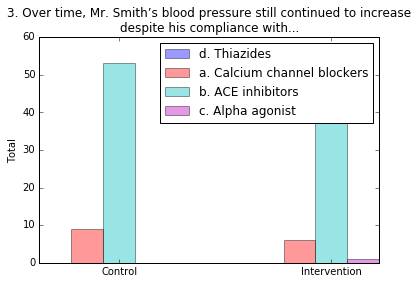

In [44]:
questionsName = '3. Over time, Mr. Smith’s blood pressure still continued to increase despite his compliance with...'
dd_number = 6
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [45]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(1.7141403958944279, 0.42440368138680495, 2, array([[  7.38095238,   7.61904762],
       [ 54.12698413,  55.87301587],
       [  0.49206349,   0.50793651]]))
Arm                                                 control  intervention
3. Over time, Mr. Smith’s blood pressure still ...                       
a. Calcium channel blockers                               9             6
b. ACE inhibitors                                        53            57
c. Alpha agonist                                          0             1


<a id='h4'></a>
### 4. What do you suspect happened with his new antihypertensive regimen
------------
*Multinomial*

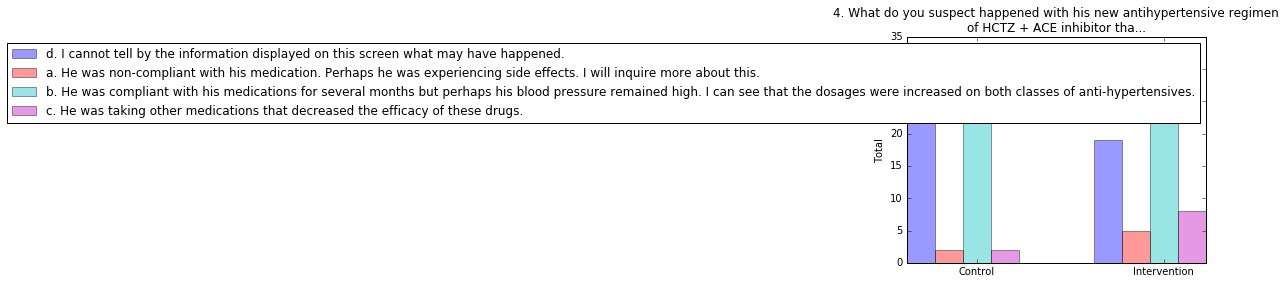

In [46]:
questionsName = '4. What do you suspect happened with his new antihypertensive regimen of HCTZ + ACE inhibitor tha...'
dd_number = 8
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [47]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(5.9443548387096783, 0.11434909180119836, 3, array([[  3.44444444,   3.55555556],
       [ 31.49206349,  32.50793651],
       [  4.92063492,   5.07936508],
       [ 22.14285714,  22.85714286]]))
Arm                                                 control  intervention
4. What do you suspect happened with his new an...                       
a. He was non-compliant with his medication. Pe...        2             5
b. He was compliant with his medications for se...       32            32
c. He was taking other medications that decreas...        2             8
d. I cannot tell by the information displayed o...       26            19


<a id='h5'></a>
### 5. Despite Mr. Smith’s diligent adherence to his exercise and diet
------------
*Multinomial*

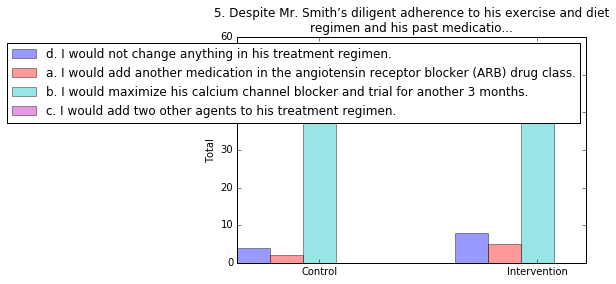

In [48]:
questionsName = '5. Despite Mr. Smith’s diligent adherence to his exercise and diet regimen and his past medicatio...'
dd_number = 11
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [49]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(2.8216573711184805, 0.24394104894615909, 2, array([[  3.44444444,   3.55555556],
       [ 52.65079365,  54.34920635],
       [  5.9047619 ,   6.0952381 ]]))
Arm                                                 control  intervention
5. Despite Mr. Smith’s diligent adherence to hi...                       
a. I would add another medication in the angiot...        2             5
b. I would maximize his calcium channel blocker...       56            51
d. I would not change anything in his treatment...        4             8


# Depression
--------

<a id='de1'></a>
### 1. You continue with your check-up. The patient has
------------
*Multiple Choice*

<a id='de2'></a>
### 2. Which drugs have been escalated in dose at least twice?
------------
*Multiple Choice*

<a id='de3'></a>
### 3. You ask Mr. Smith about the details of his depression medication changes
------------
*Multinomial*

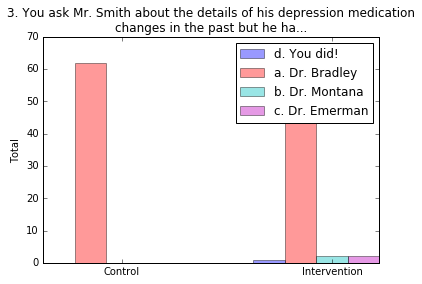

In [50]:
questionsName = '3. You ask Mr. Smith about the details of his depression medication changes in the past but he ha...'
dd_number = 7
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [51]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(5.1256613756613749, 0.16282349094083931, 3, array([[ 59.52 ,  60.48 ],
       [  0.992,   1.008],
       [  0.992,   1.008],
       [  0.496,   0.504]]))
Arm                                                 control  intervention
3. You ask Mr. Smith about the details of his d...                       
a. Dr. Bradley                                           62            58
b. Dr. Montana                                            0             2
c. Dr. Emerman                                            0             2
d. You did!                                               0             1


<a id='de4'></a>
### 4. You’d like to know what date that provider changed the medication so you
------------
*Multinomial*

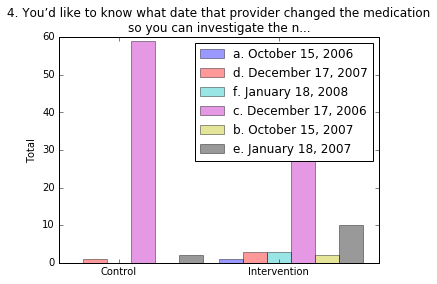

In [52]:
questionsName = '4. You’d like to know what date that provider changed the medication so you can investigate the n...'
dd_number = 10
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [53]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(14.510728039345327, 0.012670863474410449, 5, array([[  0.496,   0.504],
       [  0.992,   1.008],
       [ 51.088,  51.912],
       [  1.984,   2.016],
       [  5.952,   6.048],
       [  1.488,   1.512]]))
Arm                                                 control  intervention
4. You’d like to know what date that provider c...                       
a. October 15, 2006                                       0             1
b. October 15, 2007                                       0             2
c. December 17, 2006                                     59            44
d. December 17, 2007                                      1             3
e. January 18, 2007                                       2            10
f. January 18, 2008                                       0             3


<a id='de5'></a>
### 5. Why do you think the provider chose bupropion to prescribe in 2006?
------------
*Multinomial*

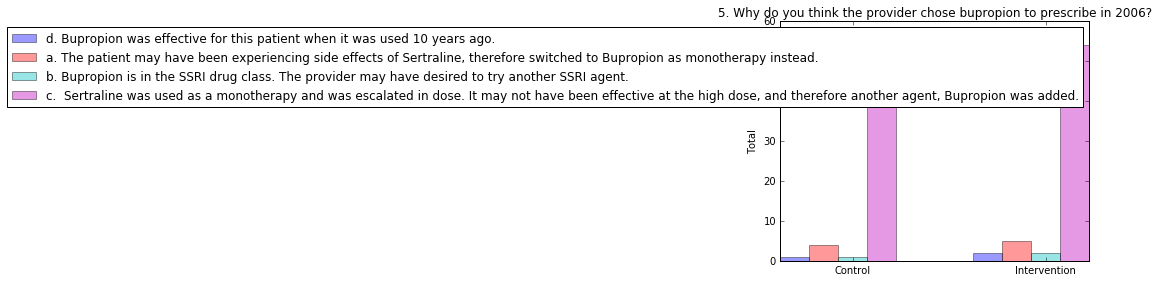

In [54]:
questionsName = '5. Why do you think the provider chose bupropion to prescribe in 2006? '
dd_number = 12
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

In [55]:
cont_table = pd.concat([cq_interve[['label',questionsName]],cq_control[['label',questionsName]]],
                       axis=0)
crosstab = pd.crosstab(cont_table[questionsName], cont_table['label'], 
            rownames=[questionsName], colnames=['Arm'])
print(scipy.stats.chi2_contingency(crosstab))
print(crosstab)

(0.80619301049408576, 0.84798518070536533, 3, array([[  4.464,   4.536],
       [  1.488,   1.512],
       [ 54.56 ,  55.44 ],
       [  1.488,   1.512]]))
Arm                                                 control  intervention
5. Why do you think the provider chose bupropio...                       
a. The patient may have been experiencing side ...        4             5
b. Bupropion is in the SSRI drug class. The pro...        1             2
c.  Sertraline was used as a monotherapy and wa...       56            54
d. Bupropion was effective for this patient whe...        1             2


[Return to Main Notebook](main_med_student.ipynb)